In [1]:
#This notebook calculates the chi2 between the fiduical dv and the dv with scale-dependant responses included

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

In [5]:
#Load all the data

#Datavector
gammat_dir = "/global/cfs/projectdirs/des/awhyley/ggl/fullscale_070624/gammat_bf_rp"
gammat = []
#iterate over source bins
for l in range(6):
    for s in range(4):
        asd = np.loadtxt(gammat_dir + '/gammat_l{0}_s{1}.txt'.format(l+1, s+1))
        gammat.append(asd[:,1])
gammat = np.array(gammat)
gammat = gammat.reshape((6,4,26))     #THIS IS UNBLINDED SO DO NOT PLOT IT
print(gammat.shape)

#Mean response per source bin
meanR_dir = "/global/cfs/projectdirs/des/awhyley/ggl/response_tests"
meanR = []
for s in range(4):
    asd = np.loadtxt(meanR_dir + "/Response_diag_bin{0}.txt".format(s))
    meanR.append(asd[0])
meanR = np.array(meanR)
print(meanR)

#Scale-dependant response
scaleR_dir = "/global/cfs/projectdirs/des/awhyley/ggl/response_tests/scale-dependent_Oct24/responses"
scaleR = []
for s in range(4):
    asd = np.loadtxt(scaleR_dir + "/Rmean_s{0}.txt".format(s+1))
    scaleR.append(asd)
scaleR = np.array(scaleR)
print(scaleR.shape)

#Angular scales for plotting
theta = np.loadtxt(gammat_dir + '/gammat_l1_s1.txt')[:,0]
scale_cuts_low = np.array([24.268, 17.6, 12.99, 10.858, 9.677, 8.7])
scale_cuts_high = 250

#DV covariance
dv_cov = fits.open('/global/cfs/projectdirs/des/awhyley/y6-3x2pt/inference/data_vectors/real/3x2pt_2025-07-28-20h_UNBLINDED_wmask.fits')
err = np.sqrt(np.diag(dv_cov[1].data[520:1144,520:1144]))
#print(err.shape)
print(dv_cov[2].data.shape)
#print(dv_cov[1].header)
#plt.imshow(dv_cov[1].data)
#plt.imshow(dv_cov[1].data[520:1144,520:1144])
#plt.show()
dv_cov_inv = np.linalg.inv(dv_cov[1].data[520:1144,520:1144])
print(dv_cov_inv.shape)

#No bin 2 covariance 
dv_cov_nob2 = fits.open('/global/cfs/projectdirs/des/awhyley/y6-3x2pt/inference/data_vectors/real/3x2pt_2025-07-28-20h_UNBLINDED_wmask_nob2.fits')
err = np.sqrt(np.diag(dv_cov_nob2[1].data[520:1144,520:1144]))
print(dv_cov_nob2[1].data.shape)

(6, 4, 26)
[0.85712719 0.86775723 0.81974834 0.69158139]
(4, 26)
(260,)
(624, 624)
(1690, 1690)


In [40]:
#This cell corrects the dv if it was computed using different responses than those loaded as meanR

oldR_dir = "/global/cfs/projectdirs/des/awhyley/ggl/response_tests"
oldR = []
for s in range(4):
    asd = np.loadtxt(oldR_dir + "/response_zbin{0}.txt".format(s+1))
    oldR.append(asd[0])
oldR = np.array(oldR)
print(oldR)   #Currently these are identical to the new values, despite being calculated with an older catalogue

#Now correct the dv
for s in range(4):
    gammat[:,s,:] = gammat[:,s,:] * oldR[s] / meanR[s]

[0.86256582 0.85947977 0.81663898 0.68256039]


In [6]:
#Construct test dv by swapping mean Rs for scale-dependant Rs and calculate the residual dv

gammat_scale = np.zeros((6,4,26))
resid = np.zeros((6,4,26))
for l in range(6):
    for s in range(4):
        for a in range(26):
            gammat_scale[l,s,a] = gammat[l,s,a] * meanR[s] / scaleR[s,a]
            resid[l,s,a] = gammat_scale[l,s,a] - gammat[l,s,a]
            
#print(resid)

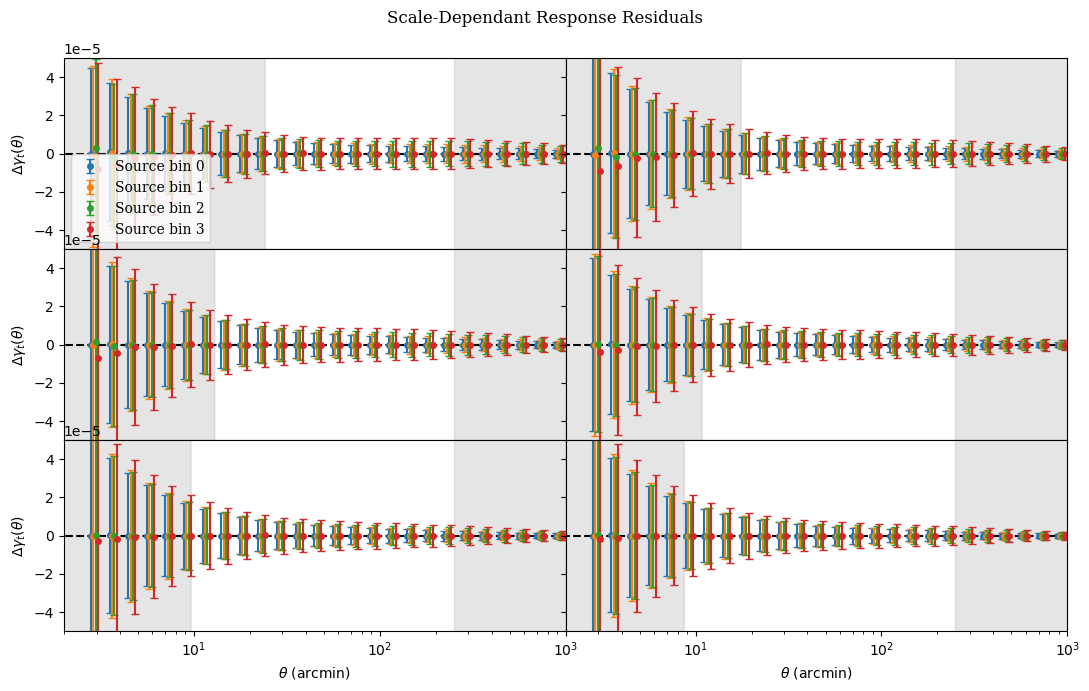

In [7]:
#Plot resids

fig, ax = plt.subplots(3,2, figsize = (11, 7), sharex = True, sharey = True)
ccc = ['dodgerblue','darkorange', 'forestgreen', 'crimson']
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.family'] = 'serif'  # Adjust font family

zerox = [0,1000]
zeroy = [0,0]

for t in range(6):
    for b in range(4):
        ax[t//2, t%2].errorbar(theta + theta * b * 0.03, resid[t][b], err.reshape(6,4,26)[t][b], 
                                label = 'Source bin {}'.format(b), fmt='o', markersize = 4, capsize=3, capthick=1)

    ax[t//2, t%2].set_xscale('log')
    #ax[t//2, t%2].set_yscale('log')
    ax[t//2, t%2].set_ylim(-0.00005, 0.00005)
    ax[t//2, t%2].set_xlim(2, 1000)
    ax[2, t%2].set_xlabel(r'$\theta$ (arcmin)')
    ax[t//2, 0].set_ylabel(r'$\Delta\gamma_t(\theta)$')
    # ax[t//2, t%2].set_title('Lens bin {}'.format(t+1))
    #ax[t//2, t%2].set_yticks([])
    #ax[t//2, t%2].text(100, 0.003, 'Lens bin {}'.format(t+1), va='center', rotation='horizontal')
    ax[t//2, t%2].fill([0,0,scale_cuts_low[t],scale_cuts_low[t]],[-0.0017,  0.0013,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[t//2, t%2].fill([scale_cuts_high,scale_cuts_high,1000,1000,],[0.0013,  -0.0017,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[0,0].legend(loc='lower left')
    
    ax[t//2, t%2].plot(zerox, zeroy, color="black", linestyle="--")
    
plt.suptitle('Scale-Dependant Response Residuals')
plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)

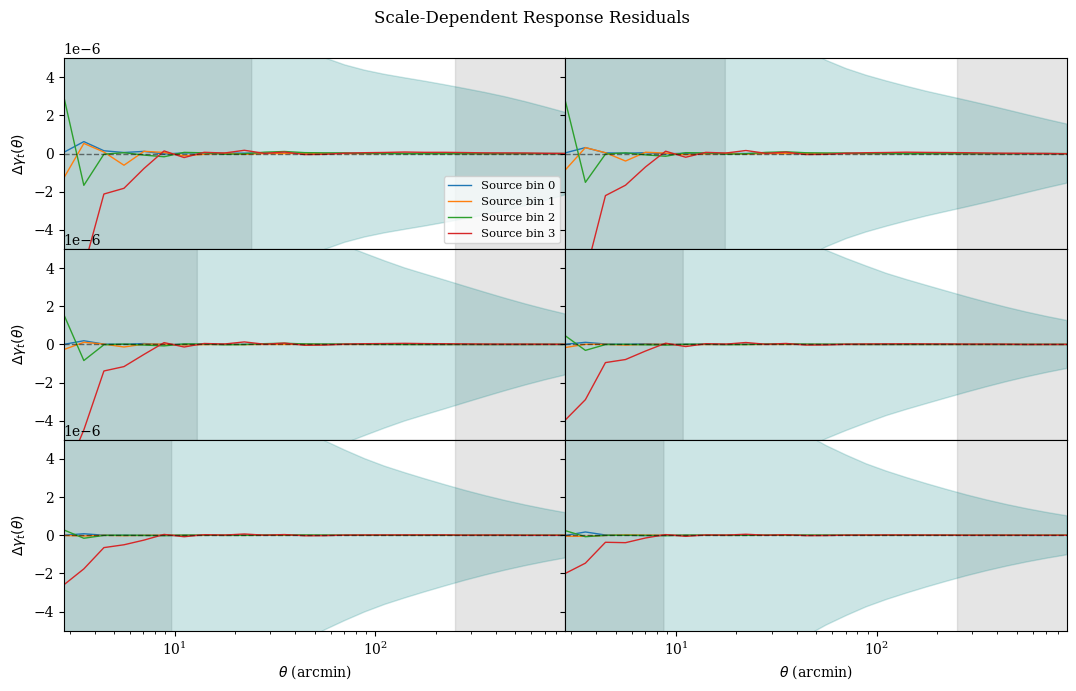

In [8]:
#Plot resids

fig, ax = plt.subplots(3,2, figsize = (11, 7), sharex = True, sharey = True)
ccc = ['dodgerblue','darkorange', 'forestgreen', 'crimson']
plt.rcParams['font.size'] = 10  # Adjust font size
plt.rcParams['font.family'] = 'serif'  # Adjust font family

zerox = theta
zeroy = np.zeros(len(theta))

for t in range(6):
    for b in range(4):
        ax[t//2, t%2].plot(theta, resid[t][b], label = 'Source bin {}'.format(b), markersize = 4, linewidth=1)

    ax[t//2, t%2].set_xscale('log')
    #ax[t//2, t%2].set_yscale('log')
    ax[t//2, t%2].set_ylim(-0.000005, 0.000005)
    ax[t//2, t%2].set_xlim(theta[0], theta[-1])
    ax[2, t%2].set_xlabel(r'$\theta$ (arcmin)')
    ax[t//2, 0].set_ylabel(r'$\Delta\gamma_t(\theta)$')
    # ax[t//2, t%2].set_title('Lens bin {}'.format(t+1))
    #ax[t//2, t%2].set_yticks([])
    #ax[t//2, t%2].text(100, 0.003, 'Lens bin {}'.format(t+1), va='center', rotation='horizontal')
    ax[t//2, t%2].fill([0,0,scale_cuts_low[t],scale_cuts_low[t]],[-0.0017,  0.0013,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[t//2, t%2].fill([scale_cuts_high,scale_cuts_high,1000,1000,],[0.0013,  -0.0017,-0.0017, 0.0013],  color='gray', alpha=0.2)
    ax[0,0].legend(loc='lower right', fontsize="small")
    
    ax[t//2, t%2].plot(zerox, zeroy, color="black", linestyle="--", linewidth=1, alpha=0.5)
    ax[t//2, t%2].fill_between(zerox, zeroy-err.reshape(6,4,26)[t][0], zeroy+err.reshape(6,4,26)[t][0], color="teal", alpha=0.2)
    
plt.suptitle('Scale-Dependent Response Residuals')
plt.tight_layout()
plt.subplots_adjust(hspace=0., wspace=0.)
plt.savefig("scale_dependent_resids.pdf", dpi=200)

In [11]:
#Compute chi2

chi2 = np.zeros([6,4])
chi2_cuts = np.zeros([6,4])
chi2_nolarge = np.zeros([6,4])
for t in range(6):
    for b in range(4):
        index_low = (t*4+b)*26
        index_high = (t*4+b+1)*26
        #print(index_low,index_high)
        chi2[t,b] = resid[t][b] @ dv_cov_inv[index_low:index_high,index_low:index_high] @ (resid[t][b]).transpose()
        r_cuts = []
        r_err_cuts = []
        for a in range(26):
            if scale_cuts_low[t] < theta[a] < scale_cuts_high:
                r_cuts.append(resid[t][b][a])
            if scale_cuts_low[t] > theta[a]:
                index_low += 1
            elif theta[a] > scale_cuts_high:
                index_high -= 1
        #print(len(r_cuts))
        r_cuts = np.array(r_cuts)
        #print(index_low,index_high)
        chi2_cuts[t,b] = r_cuts @ dv_cov_inv[index_low:index_high,index_low:index_high] @ (r_cuts).transpose()
        #chi2_nolarge[t,b] = np.sum(resid[t][b][:20]**2 / err.reshape(6,4,26)[t][b][:20]**2)

print("Full Range:")
#print(chi2)
print("dof = 624, chi2 =",np.sum(chi2))
print("Scale Cuts:")
#print(chi2_cuts)
print("dof = 348, chi2 =",np.sum(chi2_cuts))
#print("Only large scales removed:")
#print("dof = 456, chi2 =",np.sum(chi2_nolarge))
print("Scale Cuts, No Bin 2:")
print("chi2 =",np.sum(chi2_cuts[0])+np.sum(chi2_cuts[2:]))

Full Range:
dof = 624, chi2 = 0.1351151400379426
Scale Cuts:
dof = 348, chi2 = 0.0045501990830914005
Scale Cuts, No Bin 2:
chi2 = 0.0031028314935049135


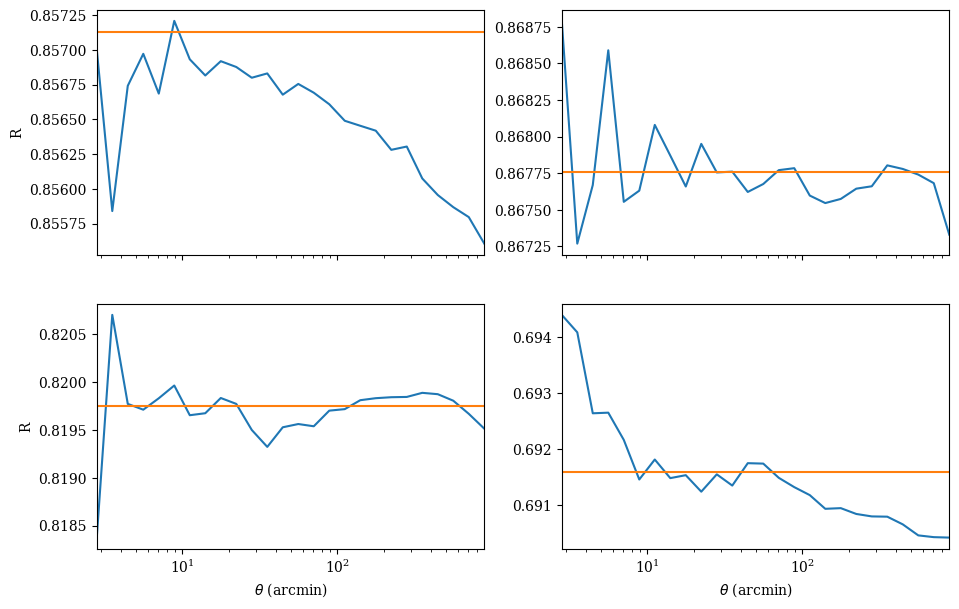

In [12]:
#Plot response comparison

fig, ax = plt.subplots(2,2, figsize = (11, 7), sharex = True, sharey = False)

for b in range(4):
    ax[b//2, b%2].plot(theta, scaleR[b])
    ax[b//2, b%2].plot([theta[0],theta[-1]], [meanR[b],meanR[b]])
    ax[b//2, b%2].set_xscale('log')
    #ax[b//2, b%2].set_ylim(meanR[b]-0.002, meanR[b]+0.002)
    ax[b//2, b%2].set_xlim(theta[0], theta[-1])
    ax[1, b%2].set_xlabel(r'$\theta$ (arcmin)')
    ax[b//2, 0].set_ylabel(r'R')

In [13]:
#What effect do we expect this to have on gammat?

gt_mock = 1e-4    #Assume this is a fiducial gt value (of similar order to Y3 dv)
gt_mock_scale = np.zeros([4,26])

for b in range(4):
    gt_mock_scale[b] = gt_mock * meanR[b] / scaleR[b]
    print(gt_mock_scale[b] - gt_mock)    #Lets us see the expected order of magnitude for the resiudals

[ 1.45621990e-08  1.50378300e-07  4.50175877e-08  1.81248211e-08
  5.15536715e-08 -9.54969370e-09  2.27204019e-08  3.63194077e-08
  2.43050884e-08  2.91834271e-08  3.82156802e-08  3.45908046e-08
  5.24566934e-08  4.34283468e-08  5.08066327e-08  6.05093503e-08
  7.44065443e-08  7.86037765e-08  8.27392352e-08  9.88450434e-08
  9.60778978e-08  1.22945907e-07  1.36866728e-07  1.47096824e-07
  1.55476617e-07  1.77799183e-07]
[-1.18992304e-07  5.62505995e-08  1.01258422e-08 -9.58784271e-08
  2.33408243e-08  1.45337211e-08 -3.72126370e-08 -1.31030639e-08
  1.12788093e-08 -2.22885603e-08  2.02041323e-10 -4.40965627e-10
  1.55684307e-08  9.29868520e-09 -1.60993970e-09 -3.15195445e-09
  1.84102480e-08  2.43149353e-08  2.10538313e-08  1.29743007e-08
  1.10918475e-08 -5.38352295e-09 -2.55048053e-09  1.88770230e-09
  8.63502827e-09  4.92257667e-08]
[ 1.67745218e-07 -1.15837727e-07 -2.69130582e-09  4.68943661e-09
 -9.82886213e-09 -2.60716630e-08  1.17373645e-08  9.19869835e-09
 -1.01853487e-08 -2.68

In [15]:
#Recalculation using covariance with point-mass marginalisation included

dv_cov = np.load('/global/cfs/projectdirs/des/awhyley/y6-3x2pt/inference/data_vectors/real/inv_cov_with_PM/inv_cov_3x2_linearcuts.npy')
print(dv_cov.shape)
#plt.imshow(dv_cov)
#plt.imshow(dv_cov[282:546,282:546])
#plt.show()

inv_cov = dv_cov[282:546,282:546]
print(inv_cov.shape)

#Cov only includes points after scale cuts, so slightly different algorithm need for chi2 calculation

err_index_low = 0
err_index_high = 0
chi2_pm_nob2 = np.zeros([6,4])
for t in range(6):
    if t != 1:
        for b in range(4):
            r_cuts = []
            for a in range(26):
                if scale_cuts_low[t] < theta[a] < scale_cuts_high:
                    r_cuts.append(resid[t][b][a])
                    err_index_high += 1
            r_cuts = np.array(r_cuts)
            chi2_pm_nob2[t,b] = np.matmul((r_cuts) ,np.matmul(inv_cov[err_index_low:err_index_high,err_index_low:err_index_high], (r_cuts).transpose()))
            print(err_index_low,err_index_high)
            err_index_low = err_index_high

print("Scale Cuts, No Bin 2, PM Marginalisation:")
#print(chi2_pm_nob2)
print("chi2 =",np.sum(chi2_pm_nob2))

(602, 602)
(264, 264)
0 10
10 20
20 30
30 40
40 53
53 66
66 79
79 92
92 106
106 120
120 134
134 148
148 162
162 176
176 190
190 204
204 219
219 234
234 249
249 264
Scale Cuts, No Bin 2, PM Marginalisation:
chi2 = 0.0032442076074911436


In [10]:
#Check PM covariance with bin 2 

dv_cov = np.load('/global/cfs/projectdirs/des/awhyley/y6-3x2pt/inference/data_vectors/real/inv_cov_with_PM/inv_cov_3x2_linearcuts_with_bin2.npy')
print(dv_cov.shape)

(320, 320)
